# REFERENCES

- Denoising Diffusion Probabilistic models
- Diffusion Meodels beat GAn on Image synthesis
- youtube video

# IMPORTS

In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

/home/dgreen/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"

In [3]:
data_dir = "/home/dgreen/sem2/dl/finalProject/LOL-v2/LOL-v2/Real_captured"

In [4]:
train_low_light_images = []
train_normal_light_images = []
test_low_light_images = []
test_normal_light_images = []

train_data_dir = os.path.join(data_dir, 'Train')
test_data_dir = os.path.join(data_dir, 'Test')

In [5]:
train_low_light_dir = os.path.join(train_data_dir, 'Low')
train_normal_light_dir = os.path.join(train_data_dir, 'Normal')
test_low_light_dir = os.path.join(test_data_dir, 'Low')
test_normal_light_dir = os.path.join(test_data_dir, 'Normal')

In [6]:
train_low_light_imgs = []
train_normal_light_imgs = []
test_low_light_imgs = []
test_normal_light_imgs = []
for filename in os.listdir(train_low_light_dir):
    if "png" in filename.strip().split(".")[-1]:
        train_low_light_imgs.append(os.path.join(train_low_light_dir, filename))

for filename in os.listdir(train_normal_light_dir):
    if "png" in filename.strip().split(".")[-1]:
        train_normal_light_imgs.append(os.path.join(train_normal_light_dir, filename))

for filename in os.listdir(test_low_light_dir):
    if "png" in filename.strip().split(".")[-1]:
        test_low_light_imgs.append(os.path.join(test_low_light_dir, filename))

for filename in os.listdir(test_normal_light_dir):
    if "png" in filename.strip().split(".")[-1]:
        test_normal_light_imgs.append(os.path.join(test_normal_light_dir, filename))
        

In [7]:
train_imgs = train_low_light_imgs + train_normal_light_imgs
test_imgs = test_low_light_imgs + test_normal_light_imgs

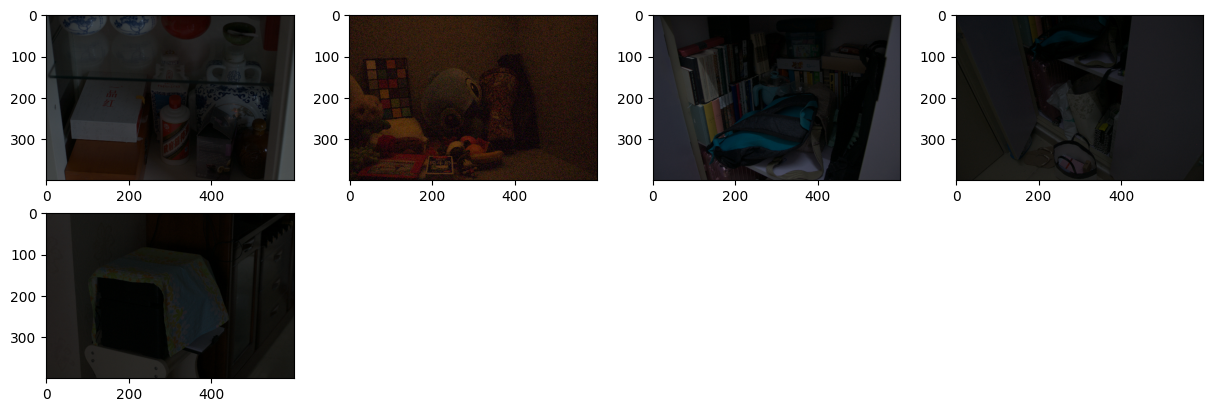

In [8]:
def show_images(data, num_samples=20, cols=4):
    """ Plots some samples from the dataset or local images """
    plt.figure(figsize=(15, 15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        if isinstance(img, str):  # Check if img is a path to a local image
            img_data = plt.imread(img)  # Load the image
            plt.imshow(img_data)
        else:  # Assume img is from the dataset
            plt.imshow(img[0])

show_images(train_imgs[0:5])

### STEP 1 : The forward process.

- The noise is added not sequentially but using closed from a paper.
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)

In [9]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset


In [30]:
def linearBetaScheduler(timesteps, start=0.0001, end=0.02): # Here we are taking 200 steps
    return torch.linspace(start, end, timesteps)

def getIndexFromList(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forwardDiffusionSample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = getIndexFromList(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = getIndexFromList(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linearBetaScheduler(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Testing on images

In [31]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image

In [32]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset(train_list, test_list):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = CustomImageDataset(train_list, transform=data_transform)
    test = CustomImageDataset(test_list, transform=data_transform)
    
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

# Example list containing filenames of images
train_list = train_imgs
test_list = test_imgs

# Load transformed dataset
data = load_transformed_dataset(train_list, test_list)

# Create DataLoader
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

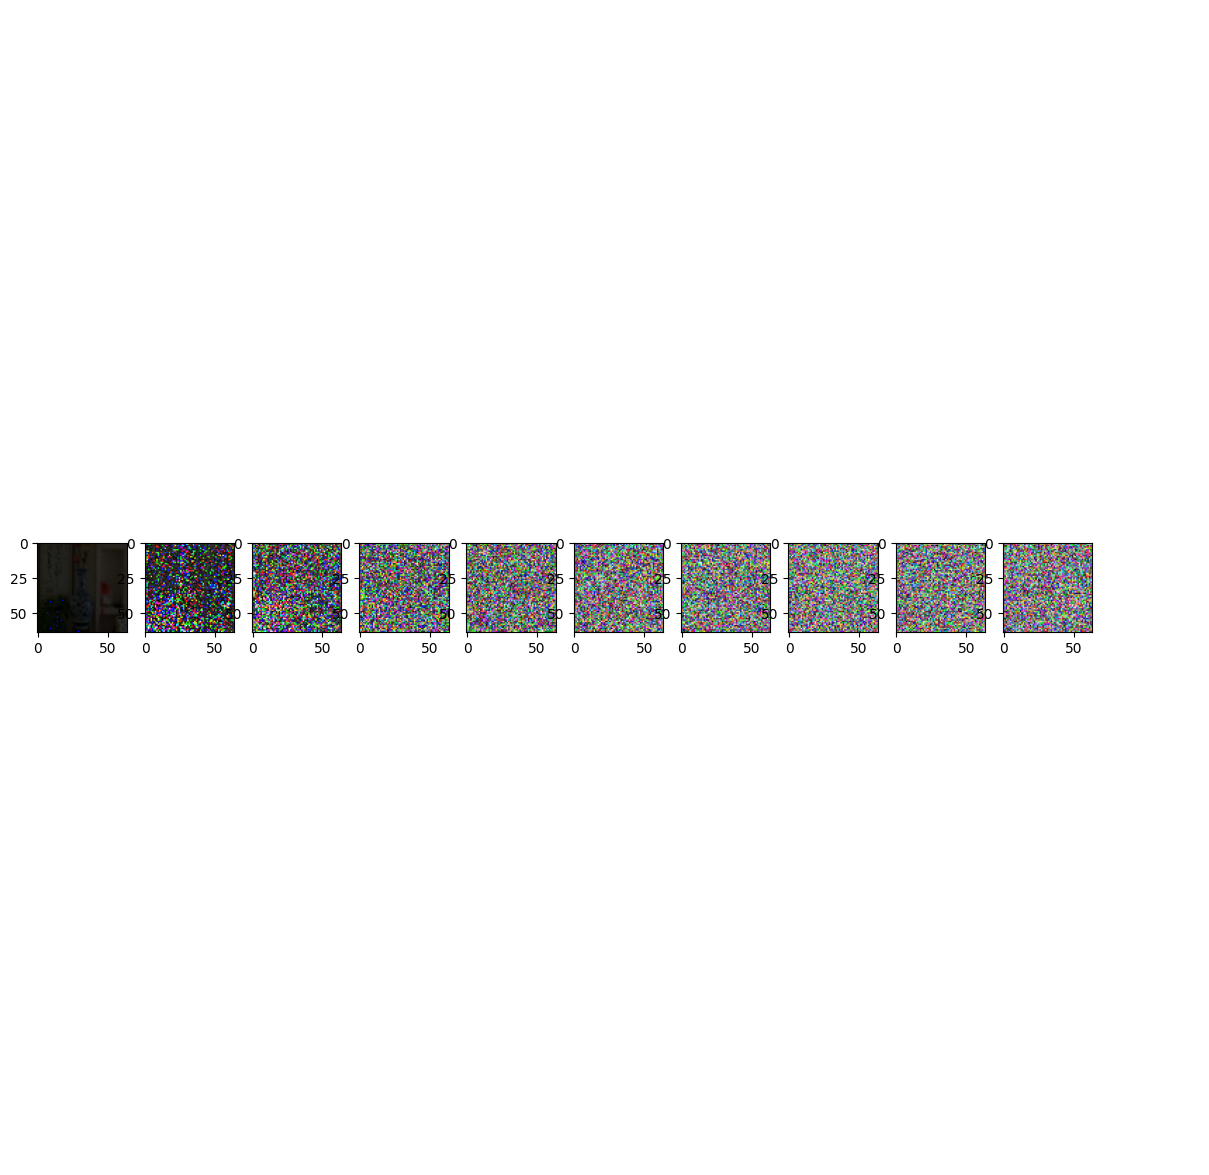

In [33]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forwardDiffusionSample(image, t)
    show_tensor_image(img)

### STEP 2 : Backward pass (U - Net)

- output has the same shape as input
- up scaling is done
- Denoising score matching
- reverse linear motion has to be done because from x_t to x_0 we need to go
- x_t-1 = x_t - predicted noise
- The input is a noisy image, the output the noise in the image

In [34]:
from torch import nn
import math

In [35]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

### STEP 3 : LOSS

In [36]:
def get_loss(model, x_0, t):
    x_noisy, noise = forwardDiffusionSample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [37]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = getIndexFromList(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = getIndexFromList(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = getIndexFromList(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = getIndexFromList(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

### Train

In [38]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 0